### Генерация лиц с помощью GAN
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>

На основе https://github.com/Lasagne/Recipes

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits

In [2]:


def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    imread = lambda x: np.array(Image.open(x))
    imresize = lambda x, size: np.array(Image.fromarray(x).resize(size))

    #image preprocessing
    
    
    imread = lambda img: plt.imread(img)
    crop = lambda img: img[dx:-dx, dy:-dy]
    resize = lambda img: np.array(Image.fromarray(img).resize((dimx, dimy)))
    
    
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(crop)\
                                 .apply(resize)

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [1]:
data, attrs = fetch_lfw_dataset(dimx=36, dimy=36)

#preprocess faces
data = np.float32(data).transpose([0,3,1,2]) / 255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

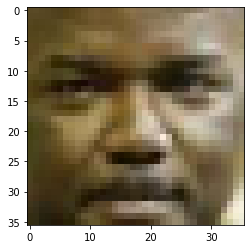

In [3]:
plt.imshow(data[np.random.randint(data.shape[0])].transpose([1,2,0]),
           cmap="gray", interpolation="none")

# ГАНЫ

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Необходимо

* построить сеть, которая генерирует лицо (маленькое изображение)
* создать __меру__ того, __насколько хорошо это лицо__
* оптимизировать градиентным спуском :)

Единственная проблема: как нам отличить хорошо сгенерированные лица от плохих?

__Если мы не можем отличить хорошие лица от плохих, пусть этим займется еще одна нейронная сеть!__

Поэтому создаются две сетки:
* __G__enerator - генератор, который берет случайный шум и пытается првратить его в лицо.
  * Обзначим его за __G__(z), где z гауссовский шум.
* __D__iscriminator - дискриминатор принимает на вход изображение человека и пытается сказать реальное хорошое лицо это или нет
  * Предсказывает вероятность, что изображение __настоящее лицо__
  * Обозначим за __D__(x), x - изображение.
  * __D(x)__ предсказание для реального изображения, а __D(G(z))__ предсказания для сгенерированного.

Для начала создадим две сетки.

In [4]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

In [5]:
CODE_SIZE = 256

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 10*8*8),
    nn.ELU(),
    Reshape([-1, 10, 8, 8]),
    nn.ConvTranspose2d(10, 64, kernel_size=5),
    nn.ELU(),
    nn.ConvTranspose2d(64, 64, kernel_size=5),
    nn.ELU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(64, 32, kernel_size=5),
    nn.ELU(),
    nn.ConvTranspose2d(32, 32, kernel_size=5),
    nn.ELU(),
    nn.Conv2d(32, 3, kernel_size=(5,5))
)

generator.to(device)

Sequential(
  (0): Linear(in_features=256, out_features=640, bias=True)
  (1): ELU(alpha=1.0)
  (2): Reshape()
  (3): ConvTranspose2d(10, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ELU(alpha=1.0)
  (5): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (6): ELU(alpha=1.0)
  (7): Upsample(scale_factor=2.0, mode=nearest)
  (8): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): ELU(alpha=1.0)
  (10): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (11): ELU(alpha=1.0)
  (12): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
)

In [6]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE

In [7]:
IMG_SHAPE

(3, 36, 36)

### Дискриминатор

In [8]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.to(device)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [9]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1),
    nn.LeakyReLU(0.2, True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    Flatten(),
    nn.Linear(2048, 1)
)

discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Flatten()
  (12): Linear(in_features=2048, out_features=1, bias=True)
)

In [10]:
discriminator(sample_data_batch(5)).shape

torch.Size([5, 1])

# Обучение

Мы обучаем две сети одновременно:
* Обучаем дискриминатор лучше отличать реальные данные от сгенерированных
* Обучаем генератор обманывать дискриминатор
* Т.к. обе сети диффренецируемы, используем градиентный спуск


Обучение проводится итеративно до тех пор, пока дискриминатор больше не сможет найти разницу (или пока у вас не закончится терпение).


### Трюки:
* Регуляризовать веса дискриминатора
* Обучаем генератор вместе с __adam__ для ускорения обучения. Дискриминатор учим с __SGD__, чтобы избежать проблем с __mometum__
* Добавим spectral norm


In [11]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = torch.mean(-logp_gen_is_real, dim=0)
    
    return loss

In [12]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1

tensor([0.6273], device='cuda:0', grad_fn=<MeanBackward1>)


In [13]:
def discriminator_loss(real_data, generated_data):
    """
    1. прогоним дискриминатор на реальных и сгенерированных данных
    2. посчитаем лог-вероятность, того что реальных данные - реальные, а сгенерированные - фейк
    3. посчитаем лосс
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)

    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)

    loss = torch.mean(-logp_real_is_real-logp_gen_is_fake, dim=0)
    return loss

In [14]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([1.3886], device='cuda:0', grad_fn=<MeanBackward1>)


### Дополнительные функции

In [15]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = F.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = F.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(), label='D(x)', alpha=0.5, range=[0,1], bins=100)
    plt.hist(D_fake.data.cpu().numpy(), label='D(G(z))', alpha=0.5, range=[0,1], bins=100)
    plt.legend(loc='best')
    plt.show()

### Обучение
Тренируем в цикле и генератор и дискриминатор. Выводим результаты каждые N итераций.

In [16]:
from torch.nn.utils import remove_spectral_norm, spectral_norm

def apply_spectral_normalization(m, remove=False):
    for name, module in m.named_children():
        apply_spectral_normalization(module)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        if remove:
            remove_spectral_norm(m)
        else:
            spectral_norm(m)

# apply_spectral_normalization(generator)
apply_spectral_normalization(discriminator)

In [17]:
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

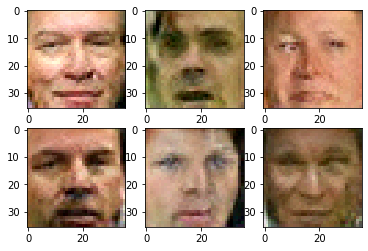

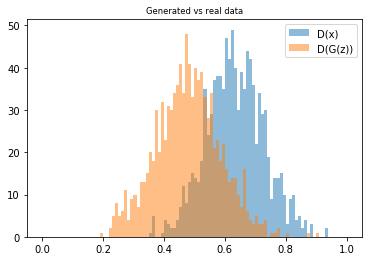

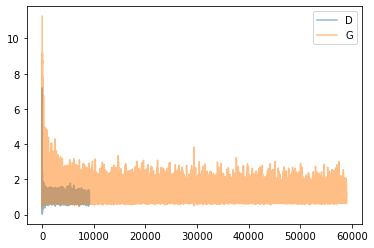

In [18]:
from IPython import display
from tqdm import tnrange

try:
    generator.load_state_dict(torch.load('generator.pth'))
    generator.to(device)
    discriminator.load_state_dict(torch.load('discriminator.pth'))
    discriminator.to(device)
except FileNotFoundError:
    batch_size = 100
    losses = {'g': [], 'd': []}
    for epoch in tnrange(3000):
        generator.train()
        discriminator.train()
        print("Epoch: {}".format(epoch))
        
        # Train discriminator
        for p in discriminator.parameters():
            p.requires_grad = True
#         while True:
            disc_opt.zero_grad()
            real_data = sample_data_batch(batch_size)
            fake_data = generator(sample_noise_batch(batch_size))
            loss = discriminator_loss(real_data, fake_data.detach())
            loss.backward()
            disc_opt.step()
            losses['d'].append(loss.item())
#             if loss.item() < 0.8:
#                 break

        # Train generator
        for p in discriminator.parameters():
            p.requires_grad = False
#         while True:
            gen_opt.zero_grad()
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            loss.backward()
            gen_opt.step()
            losses['g'].append(loss.item())
#             if loss.item() < 0.7:
#                 break

#         if epoch % 10 == 0 :
        discriminator.eval()
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        plt.plot(losses['d'], alpha=0.5, label='D')
        plt.plot(losses['g'], alpha=0.5, label='G')
        plt.legend()
        plt.show()
    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')

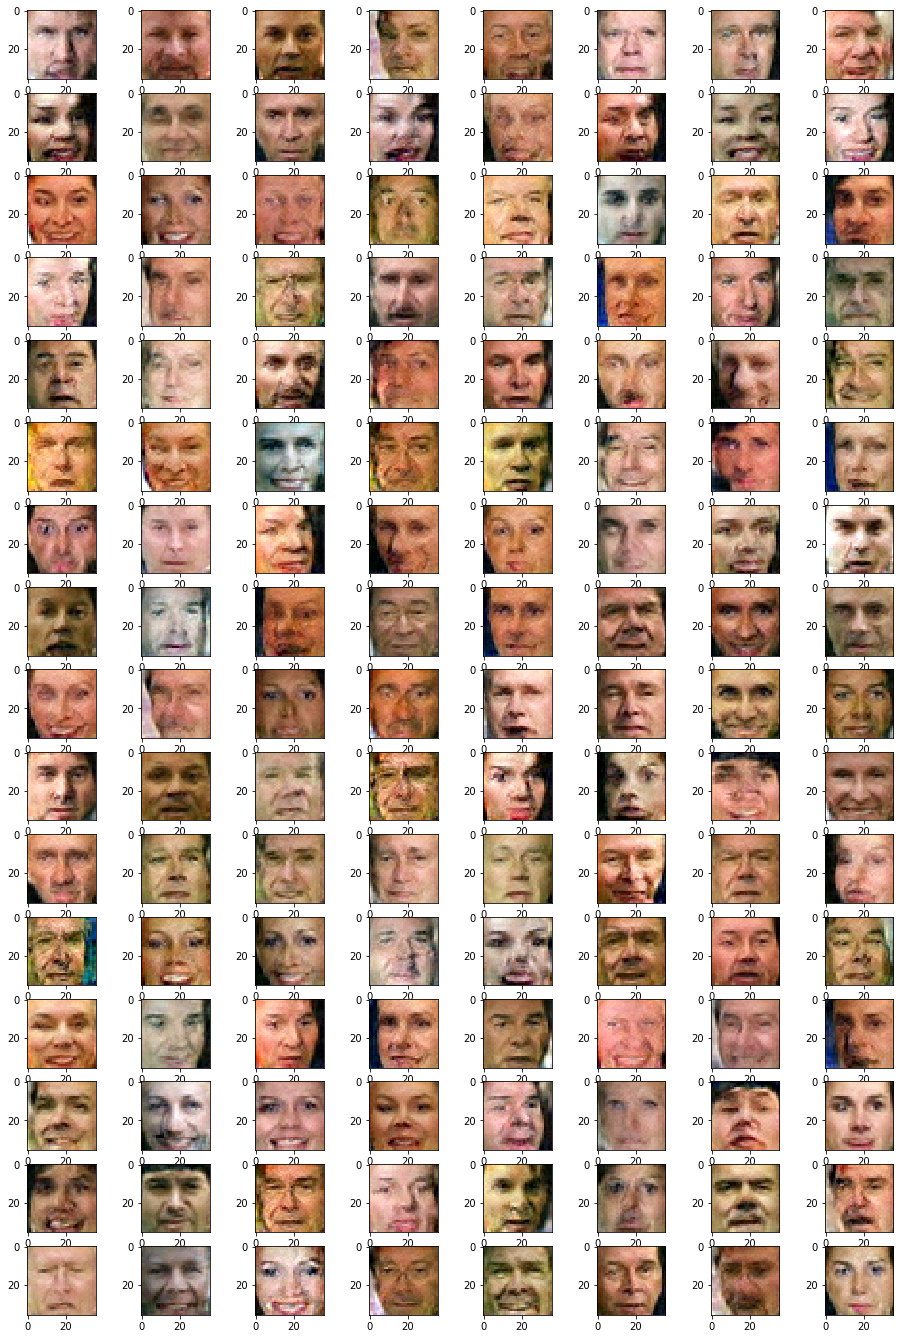

In [19]:
plt.figure(figsize=[16, 24])
sample_images(16, 8)